# Assignment 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff

In [2]:
# Load data:
data = pd.read_csv("A3_BitcoinTransactions.csv")

firstDate = data["Date"].iloc[0]
lastDate = data["Date"].iloc[-1]

# Split data into training and testing:
trainSize = 3146
trainData, testData = train_test_split(data, train_size= trainSize, shuffle= False)

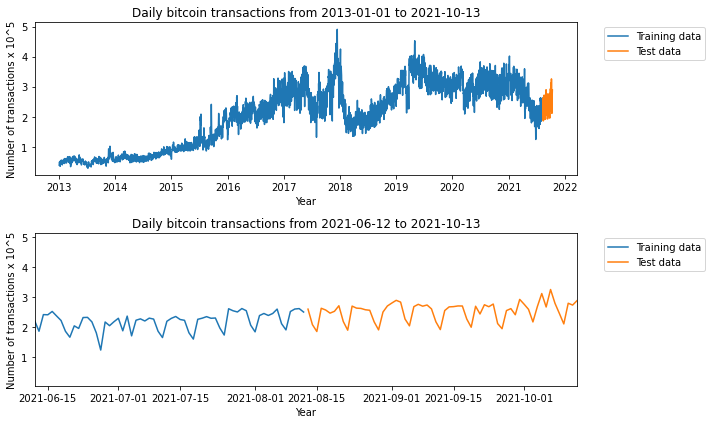

In [3]:
# Plot data:
plt.figure("BitcoinTransactions", figsize=(10,6))
plt.subplot(211)
plt.plot(pd.to_datetime(trainData["Date"]) ,trainData["BitcoinTransactions"])
plt.plot(pd.to_datetime(testData["Date"]), testData["BitcoinTransactions"])
plt.title(f"Daily bitcoin transactions from {firstDate} to {lastDate}")
plt.xlabel("Year")
plt.ylabel("Number of transactions x 10^5")
plt.legend(["Training data", "Test data"], bbox_to_anchor=(1.04,1), loc="upper left")
plt.yticks(ticks= [100000, 200000, 300000, 400000, 500000], labels= [1, 2, 3, 4, 5])

firstDateZoomed = trainData["Date"].iloc[-len(testData)]
lastDateZoomed = lastDate

plt.subplot(212)
plt.plot(pd.to_datetime(trainData["Date"]),trainData["BitcoinTransactions"])
plt.plot(pd.to_datetime(testData["Date"]), testData["BitcoinTransactions"])
plt.title(f"Daily bitcoin transactions from {firstDateZoomed} to {lastDateZoomed}")
plt.xlabel("Year")
plt.ylabel("Number of transactions x 10^5")
plt.legend(["Training data", "Test data"], bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlim(pd.Timestamp(firstDateZoomed), pd.Timestamp(lastDateZoomed))
plt.yticks(ticks= [100000, 200000, 300000, 400000, 500000], labels= [1, 2, 3, 4, 5])

plt.tight_layout()

# Save plot:
plt.savefig("figures/BitcoinTransactions.png", dpi= 300)

/Users/emilhaugstvedt/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


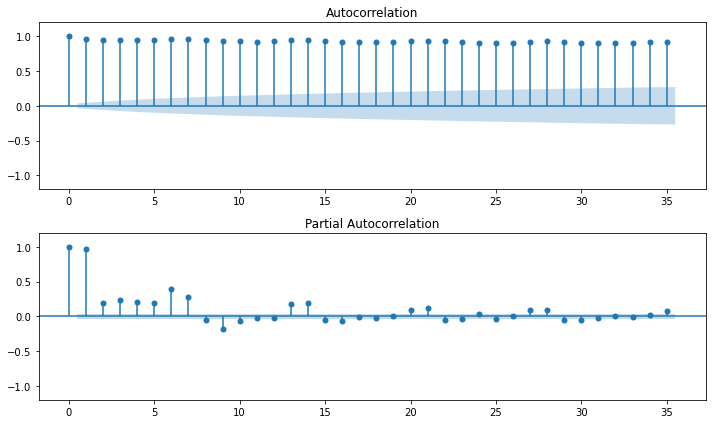

In [101]:
# Plot acf and pacf:
fig = plt.figure(figsize= (10,6))
ax1 = plt.subplot(211)
acfPlot = plot_acf(trainData["BitcoinTransactions"], ax1)
plt.ylim((-1.2, 1.2))

ax2 = plt.subplot(212)
pacfPlot = plot_pacf(trainData["BitcoinTransactions"], ax2)
plt.ylim((-1.2, 1.2))

plt.tight_layout()

fig.savefig("figures/acfpacfPlot.png", dpi= 300)

### Model plot
The above time series are non-stationary with both the mean and variance changing over time. This implies ARIMA model with the "I" term to compansate for the non-stationarity. Also from the lower plot is is clear that there are som daily patterns in the data. These patterns is an indicator that some kind of seasonality can be included in the model.

In order to find the order of the "d" part of the ARIMA model, differentiation is used. The order of the "d" is the number of differentiations that need to be used in order to get a sufficiently fast decrease in the autocorrelation function.

### Autocorrelation plot:
The autocorrelation plot are very slowly decaying. This is a clear sign of non-stationarity.

### Partial autocorrelation plot:
From this plot there looks to be seasonality in the MA part of the model. This can be seen as the significant spikes in the data with a periodicity of approximatley 12.

### Transformations:
To "make" this process stationary transformation and differencing are used. 

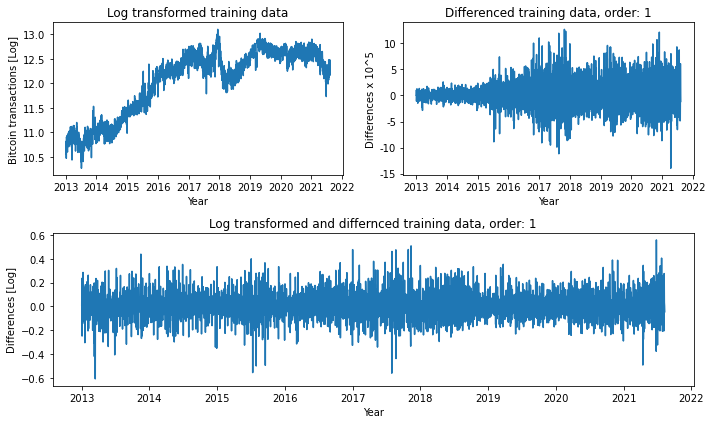

In [86]:
# Order of differencing:
diffOrder = 1

# Do the log transformation and differencing:
logTrainData = np.log(np.array(trainData["BitcoinTransactions"]))
diffTrainData = diff(np.array(trainData["BitcoinTransactions"]))

diffLogTrainData = diff(logTrainData, diffOrder)

# Plotting:
plt.figure(figsize= (10, 6))
plt.subplot(221)
plt.plot(pd.to_datetime(trainData["Date"]), logTrainData)
plt.title("Log transformed training data")
plt.ylabel("Bitcoin transactions [Log]")
plt.xlabel("Year")

plt.subplot(222)
plt.plot(pd.to_datetime(trainData["Date"]).iloc[:len(diffTrainData)], diffTrainData)
plt.title(f"Differenced training data, order: {diffOrder}")
plt.xlabel("Year")
plt.ylabel("Differences x 10^5")
plt.yticks(ticks= [-150000, -100000, -50000, 0, 50000, 100000], labels= [-15, -10, -5, 0, 5, 10])

plt.subplot(212)
plt.plot(pd.to_datetime(trainData["Date"]).iloc[:len(diffLogTrainData)], diffLogTrainData)
plt.title(f"Log transformed and differnced training data, order: {diffOrder}")
plt.ylabel("Differences [Log]")
plt.xlabel("Year")

plt.tight_layout()

# Save plot:
plt.savefig("figures/transformedDifferenced.png", dpi= 300)

### Differentiation:
The above plots are used to find the "d" term in the ARIMA model. We are supposed to find the order of the differentiation that results in a fast enough decrease in the autocorrelation function. By trying different orders, the correct "d" looks to be either 1 or 2.

/Users/emilhaugstvedt/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


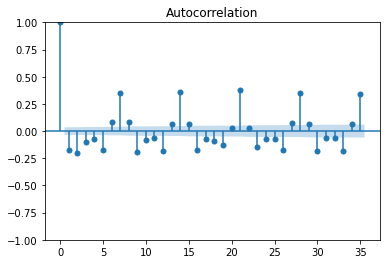

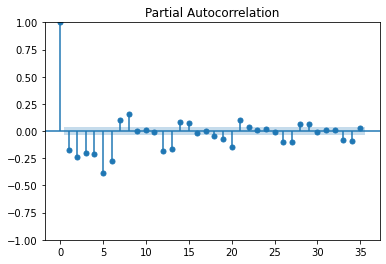

In [87]:
transformedAcf = plot_acf(diffLogTrainData)
transformedPacf = plot_pacf(diffLogTrainData)

From the above plots showing the transformed data and the autocorrelationa and autocorrelation plot there can be seen a clear seasonality of 7 both in the acf and pacf.

In [88]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (3, 1, 5)
seasonalOrder = (0, 0, 0, 0)
mean = np.mean(np.array(data["BitcoinTransactions"]))

model = SARIMAX(np.array(trainData["BitcoinTransactions"]),
                order= order,
                seasonal_order= seasonalOrder,
                enforce_invertibility= False,
                enforce_stationarity= False, 
                trend= 'c')

res = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14894D+01    |proj g|=  5.30749D-01


 This problem is unconstrained.



At iterate    5    f=  1.14336D+01    |proj g|=  1.68518D-01

At iterate   10    f=  1.13903D+01    |proj g|=  1.73601D-01

At iterate   15    f=  1.13408D+01    |proj g|=  2.96614D-01

At iterate   20    f=  1.13321D+01    |proj g|=  8.58983D-02

At iterate   25    f=  1.13303D+01    |proj g|=  7.36738D-01

At iterate   30    f=  1.13292D+01    |proj g|=  1.07253D-01

At iterate   35    f=  1.13279D+01    |proj g|=  4.45008D-01

At iterate   40    f=  1.13261D+01    |proj g|=  5.46569D-02

At iterate   45    f=  1.13260D+01    |proj g|=  1.34087D-02

At iterate   50    f=  1.13260D+01    |proj g|=  1.07674D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/emilhaugstvedt/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [89]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3146
Model:               SARIMAX(3, 1, 5)   Log Likelihood              -35631.629
Date:                Mon, 08 Nov 2021   AIC                          71283.259
Time:                        11:37:45   BIC                          71343.776
Sample:                             0   HQIC                         71304.977
                               - 3146                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    201.5107    141.101      1.428      0.153     -75.042     478.064
ar.L1          0.8973      0.146      6.129      0.000       0.610       1.184
ar.L2         -0.5638      0.183     -3.087      0.0

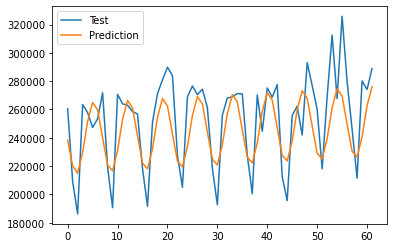

In [90]:
forecast = res.get_forecast(len(testData))

# Do the log transformation and differencing:
logTestData = np.log(np.array(testData["BitcoinTransactions"]))
diffTestData = diff(np.array(testData["BitcoinTransactions"]))

diffLogTestData = diff(logTestData, diffOrder)

mean = np.mean(np.array(data["BitcoinTransactions"]))

plt.plot(np.array(testData["BitcoinTransactions"]))
plt.plot(forecast.predicted_mean)
plt.legend(["Test", "Prediction"])

In [80]:
res.standardized_forecasts_error

array([[22.50857759,  0.2699563 ,  0.53816913, ...,  0.19398335,
         0.2599775 , -0.27439773]])